C:\Users\talha\AppData\Local\Temp\ipykernel_4788\1904623651.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\talha\AppData\Local\Temp\ipykernel_4788\1904623651.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Model Accuracy: 0.8212290502793296

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



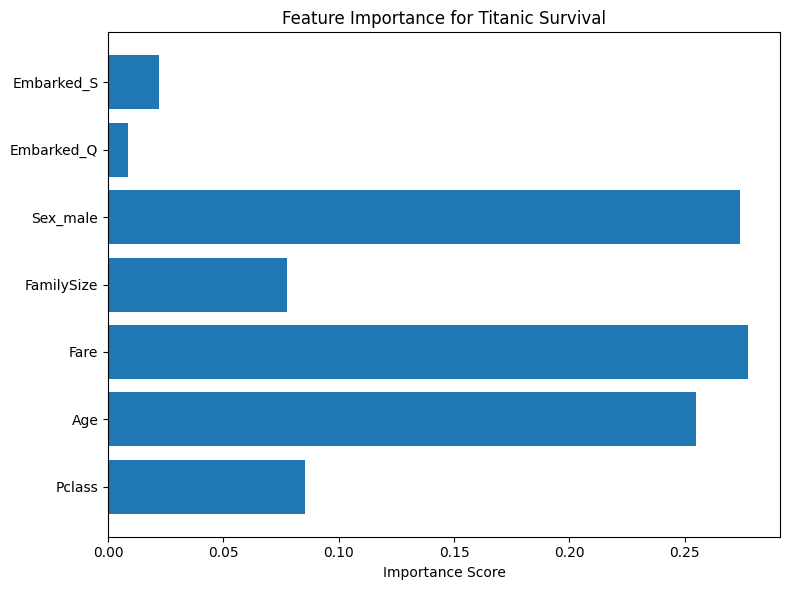


Prediction for sample passenger: Survived
Survival Probability: 98.00%


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Titanic-Dataset.csv')

# Clean data: Keep only relevant columns
df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]

# Fill missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Add engineered feature: FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch']

# Define features and target
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize']]
y = df['Survived']

# Categorical and numerical columns
categorical_features = ['Sex', 'Embarked']
numerical_features = ['Pclass', 'Age', 'Fare', 'FamilySize']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create pipeline with preprocessor and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importances from model
model = pipeline.named_steps['classifier']
feature_names = (
    numerical_features +
    list(pipeline.named_steps['preprocessor']
         .transformers_[1][1]
         .get_feature_names_out(categorical_features))
)
importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance Score')
plt.title('Feature Importance for Titanic Survival')
plt.tight_layout()
plt.show()

# Predict a sample passenger
sample_data = pd.DataFrame([{
    'Pclass': 2,
    'Sex': 'female',
    'Age': 28,
    'Fare': 30,
    'Embarked': 'C',
    'FamilySize': 1
}])

sample_prediction = pipeline.predict(sample_data)[0]
sample_proba = pipeline.predict_proba(sample_data)[0][1]

print(f"\nPrediction for sample passenger: {'Survived' if sample_prediction == 1 else 'Did not survive'}")
print(f"Survival Probability: {sample_proba:.2%}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\talha\AppData\Local\Temp\ipykernel_4788\3688376568.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Epoch 5/20, Loss: 0.051682
Epoch 10/20, Loss: 0.048756
Epoch 15/20, Loss: 0.042403
Epoch 20/20, Loss: 0.030363


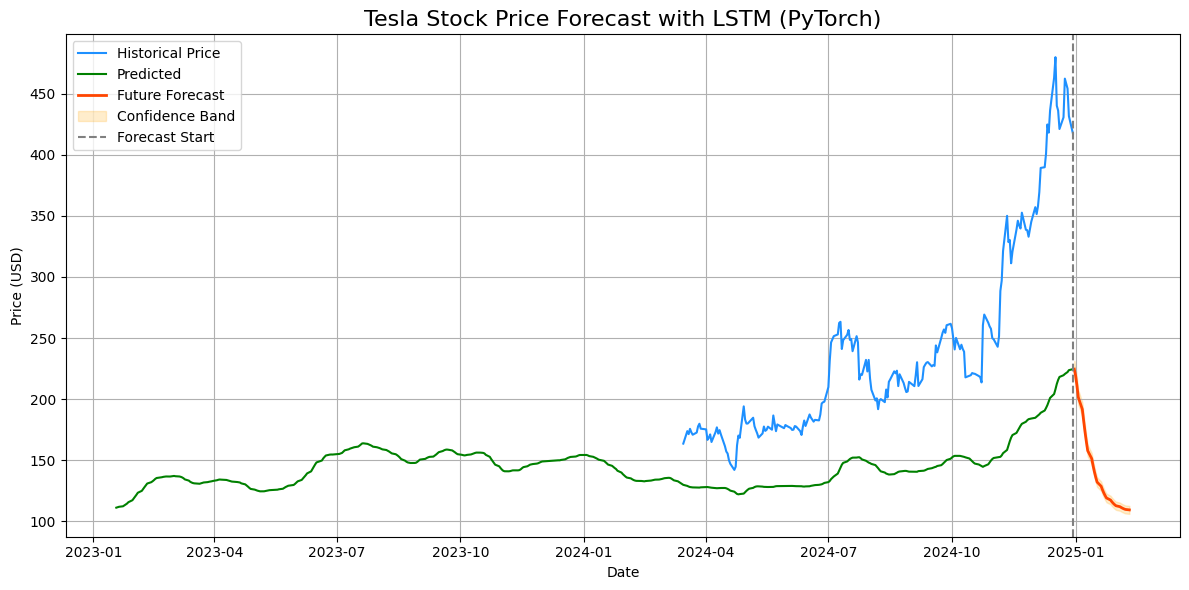

In [3]:
# 📦 Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# 📈 Load TSLA stock data
df = yf.download('TSLA', start='2015-01-01', end='2024-12-31')
df = df[['Close']].dropna()

# 🔢 Normalize Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 📏 Create Sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

SEQ_LEN = 60
X, y = create_sequences(scaled_data, SEQ_LEN)

# 📊 Split into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 🔧 Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 🏋️ Training
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")

# 📈 Predict on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    y_test_np = y_test.numpy()

# Inverse scale
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test_np.reshape(-1, 1))

# 🔮 Future Forecast (Next 30 Days)
future_seq = X[-1].unsqueeze(0)
future_preds = []

with torch.no_grad():
    for _ in range(30):
        next_pred = model(future_seq)[:, -1]
        future_preds.append(next_pred.item())
        new_seq = torch.cat((future_seq[:, 1:, :], next_pred.view(1, 1, 1)), dim=1)
        future_seq = new_seq

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 📅 Future Dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='B')

# 📊 Plot: Actual vs Prediction with Unique Graph
plt.figure(figsize=(12, 6))
plt.plot(df.index[-200:], df['Close'][-200:], label="Historical Price", color='dodgerblue')
plt.plot(df.index[-len(predicted_prices):], predicted_prices, label="Predicted", color='green')
plt.plot(future_dates, future_prices, label="Future Forecast", color='orangered', linewidth=2)

# Add Confidence Band
upper = future_prices * 1.03
lower = future_prices * 0.97
plt.fill_between(future_dates, lower.flatten(), upper.flatten(), color='orange', alpha=0.2, label="Confidence Band")

plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("Tesla Stock Price Forecast with LSTM (PyTorch)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
